In [1]:
# Import system packages
using Printf
using DelimitedFiles
using Plots
using LaTeXStrings

In [2]:
# Import AGNI
ROOT_DIR = abspath(pwd(),"../")
using AGNI

# Disable logging from AGNI module
AGNI.setup_logging("",1)

In [3]:
R_earth = 6.371e6
M_earth = 5.972e24

5.972e24

In [4]:
# Configuration options
instellation    = 6501.0
mass            = 1.873*M_earth
radius          = 1.265*R_earth
gravity         = 6.67e-11 * mass / radius^2
p_surf          = 1e3
tmp_surf        = 3100.0
s0_fact         = 0.25
zenith_degrees  = 54.74
albedo_b        = 0.0
nlev_centre     = 50
p_top           = 1e-5      # bar

x_H2O = 0.01
mole_fractions  = Dict([
                        ("H2O", x_H2O),
                        ("H2" , 1-x_H2O)
                    ])
thermo          = true
real_gas        = true

phys.ENABLE_AQUA = false

albedo_data   = joinpath(ROOT_DIR,"res/surface_albedos/lunar_marebasalt.dat")
spectral_file = joinpath(ROOT_DIR,"res/spectral_files/Dayspring/48/Dayspring.sf")
star_file     = joinpath(ROOT_DIR,"res/stellar_spectra/sun.txt")
output_dir    = joinpath(ROOT_DIR,"out/")

"/dataserver/users/formingworlds/nicholls/AGNI/out/"

In [5]:
# Create output directory
rm(output_dir,force=true,recursive=true)
mkdir(output_dir);

In [6]:
# Setup atmosphere
atmos = atmosphere.Atmos_t()
atmosphere.setup!(atmos, ROOT_DIR, output_dir,
                        spectral_file,
                        instellation, s0_fact, albedo_b, zenith_degrees,
                        tmp_surf,
                        gravity, radius,
                        nlev_centre, p_surf, p_top,
                        mole_fractions, "",

                        flux_int = 0.0,
                        flag_gcontinuum=true,
                        flag_rayleigh=true,
                        real_gas=real_gas,
                        thermo_functions=thermo,
                        surface_material=albedo_data
                    )
atmosphere.allocate!(atmos, star_file)

[ INFO  ] Setting-up a new atmosphere struct 
[ INFO  ] Loading thermodyamic data 
[ INFO  ] Inserting stellar spectrum and Rayleigh coefficients 
[ INFO  ] Allocating atmosphere with composition: 
[ INFO  ]       1 H2O     1.00e-02 (EOS_VDW) 
[ INFO  ]       2 H2      9.90e-01 (EOS_CMS19) 


true

In [ ]:
x_arr = collect(Float64, logrange(start=0.0, stop=1.0, length=5))
nsamps = length(x_arr)

5

In [20]:
atm_arr_ide = atmosphere.Atmos_t[]
atm_arr_rea = atmosphere.Atmos_t[]

@printf("Running ideal gas model for %d samples... \n", nsamps)
atmos.gas_dat["H2O"].eos = phys.EOS_IDEAL
atmos.gas_dat["H2"].eos = phys.EOS_IDEAL
for i in 1:nsamps
    @printf("    sample %d/%d \n",i,nsamps)

    # update planet
    x_H2O = x_arr[i]
    println("x_H2O = $x_H2O")
    fill!(atmos.gas_vmr["H2O"], x_H2O)
    fill!(atmos.gas_vmr["H2"], 1-x_H2O)
    setpt.dry_adiabat!(atmos)
    setpt.saturation!(atmos, "H2O")

    # Run model
    atmosphere.calc_layer_props!(atmos)
    energy.radtrans!(atmos, true)
    energy.radtrans!(atmos, false)
    atmosphere.calc_observed_rho!(atmos)

    # Store result
    push!(atm_arr_ide, deepcopy(atmos))
    @printf("--------------------------------- \n")
end

@printf("Running real gas model for %d samples... \n", nsamps)
atmos.gas_dat["H2O"].eos = phys.EOS_VDW
atmos.gas_dat["H2"].eos = phys.EOS_CMS19
for i in 1:nsamps
    @printf("    sample %d/%d \n",i,nsamps)

    # update planet
    x_H2O = x_arr[i]
    println("x_H2O = $x_H2O")
    fill!(atmos.gas_vmr["H2O"], x_H2O)
    fill!(atmos.gas_vmr["H2"], 1-x_H2O)
    setpt.dry_adiabat!(atmos)
    setpt.saturation!(atmos, "H2O")

    # Run model
    atmosphere.calc_layer_props!(atmos)
    energy.radtrans!(atmos, true)
    energy.radtrans!(atmos, false)
    atmosphere.calc_observed_rho!(atmos)

    # Store result
    push!(atm_arr_rea, deepcopy(atmos))
    @printf("--------------------------------- \n")
end

println("Done!")

Running ideal gas model for 5 samples... 
    sample 1/5 
x_H2O = 0.0
--------------------------------- 
    sample 2/5 
x_H2O = 0.25
--------------------------------- 
    sample 3/5 
x_H2O = 0.5
--------------------------------- 
    sample 4/5 
x_H2O = 0.75
--------------------------------- 
    sample 5/5 
x_H2O = 1.0
--------------------------------- 
Running real gas model for 5 samples... 
    sample 1/5 
x_H2O = 0.0
--------------------------------- 
    sample 2/5 
x_H2O = 0.25
--------------------------------- 
    sample 3/5 
x_H2O = 0.5
--------------------------------- 
    sample 4/5 
x_H2O = 0.75
--------------------------------- 
    sample 5/5 
x_H2O = 1.0
--------------------------------- 
Done!


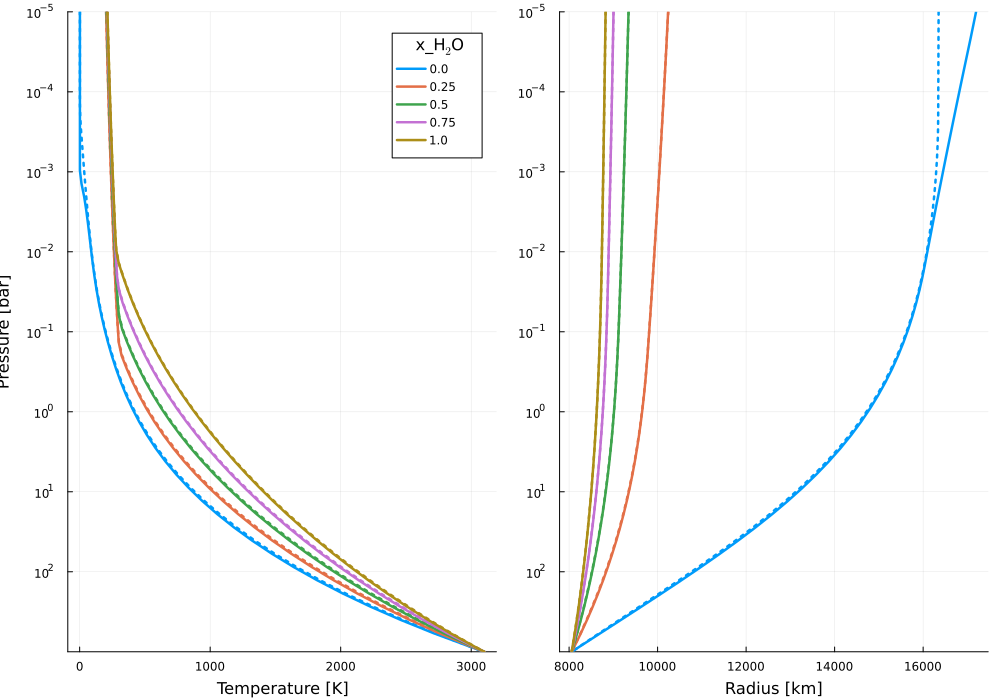

In [21]:
arr_P = atmos.pl / 1.0e5 # Convert Pa to bar
ylims  = (arr_P[1], arr_P[end])
yticks = 10.0 .^ round.(Int,range( log10(ylims[1]), stop=log10(ylims[2]), step=1))

axl = plot(xlabel="Temperature [K]", legend=:topright, ylabel="Pressure [bar]", legendtitle=L"x_H$_2$O")
axr = plot(xlabel="Radius [km]")

p = Plots.palette(:default)
lw = 2.5
for i in 1:nsamps
    c = p[i]

    # real gas
    plot!(axl, atm_arr_rea[i].tmpl,   atm_arr_rea[i].pl/1e5, lc=c, lw=lw, label=x_arr[i])
    plot!(axr, atm_arr_rea[i].rl/1e3, atm_arr_rea[i].pl/1e5, lc=c, lw=lw, label="")

    # ideal gas
    # real gas
    plot!(axl, atm_arr_ide[i].tmpl,   atm_arr_ide[i].pl/1e5, lc=c, lw=lw, ls=:dot, label="")
    plot!(axr, atm_arr_ide[i].rl/1e3, atm_arr_ide[i].pl/1e5, lc=c, lw=lw, ls=:dot, label="")
end

for ax in (axl, axr)
    yflip!(ax)
    yaxis!(ax, yscale=:log10,ylims=ylims, yticks=yticks)
end


fig = plot(axl, axr, size=(1000,700))
display(fig)